In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import math


# EDA

In [18]:
df = pd.read_csv("COVID-19 POSITIVE CASES_MARCH_2020_DEC_2022.csv", thousands=",")
df.head()

,PROVINCE,DISTRICT,POPULATION,2020 14,2020 15,2020 16,2020 17,2020 18,2020 19,2020 20,...,2022 45,2022 46,2022 47,2022 48,2022 49,2022 50,2022 51,2022 52,2022 Total,Grand Total
0,CABO_DELGADO,ANCUABE,159340,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,89
1,CABO_DELGADO,BALAMA,175733,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,114,220
2,CABO_DELGADO,CHIURE,299235,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,10,351,724
3,CABO_DELGADO,IBO,12205,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,69,112
4,CABO_DELGADO,MACOMIA,114345,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Aggregate to province level

In [19]:
province_df = df.groupby("PROVINCE").sum(numeric_only=True)
province_df.reset_index(inplace=True)

Reshape wide to long and remove "2021 Total, 2022 Total, and Grand Total" columns

In [20]:
total_bool = province_df.columns.str.contains("Total")
week_cols = province_df.columns[~total_bool]
week_cols = week_cols.drop("POPULATION")
long_province_df = pd.melt(province_df, id_vars="PROVINCE", value_vars=week_cols, var_name="Week", value_name="Cases")

In [21]:
# hacky way to get into datetimes
year = pd.to_numeric(long_province_df.Week.str.slice(stop=4))
week = pd.to_numeric(long_province_df.Week.str.slice(start=-2))
dates = year*100 + (week-1)
dates = dates.astype(str) + '3'
dates = dates.replace("2022003", "2022004")
long_province_df["date"] = pd.to_datetime(dates, format='%Y%W%w')
long_province_df.set_index("date", inplace=True)
long_province_df.drop("Week", axis=1, inplace=True)

Smooth with a 3-week moving average

In [22]:
n = 3

long_province_df = pd.merge(
    long_province_df,
    long_province_df.groupby("PROVINCE").rolling(n, min_periods=1, center=True).mean().reset_index().rename(columns={"Cases":f"SMA{n}"}),
    on=["PROVINCE", "date"])

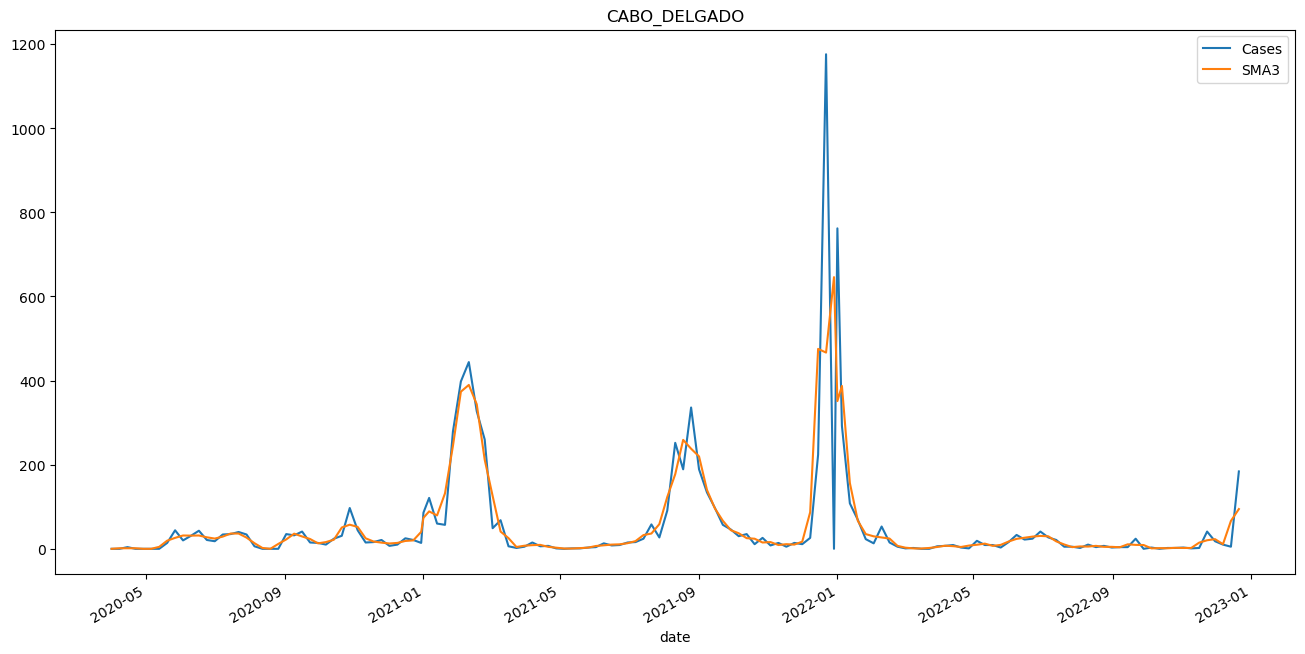

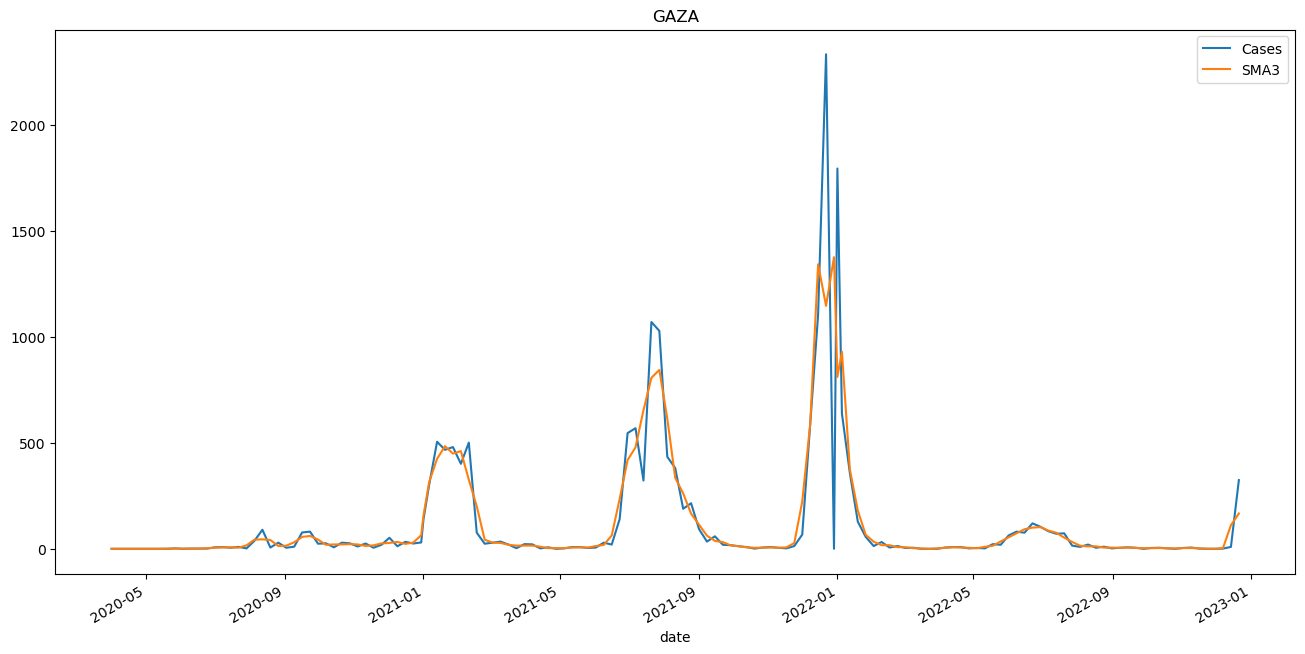

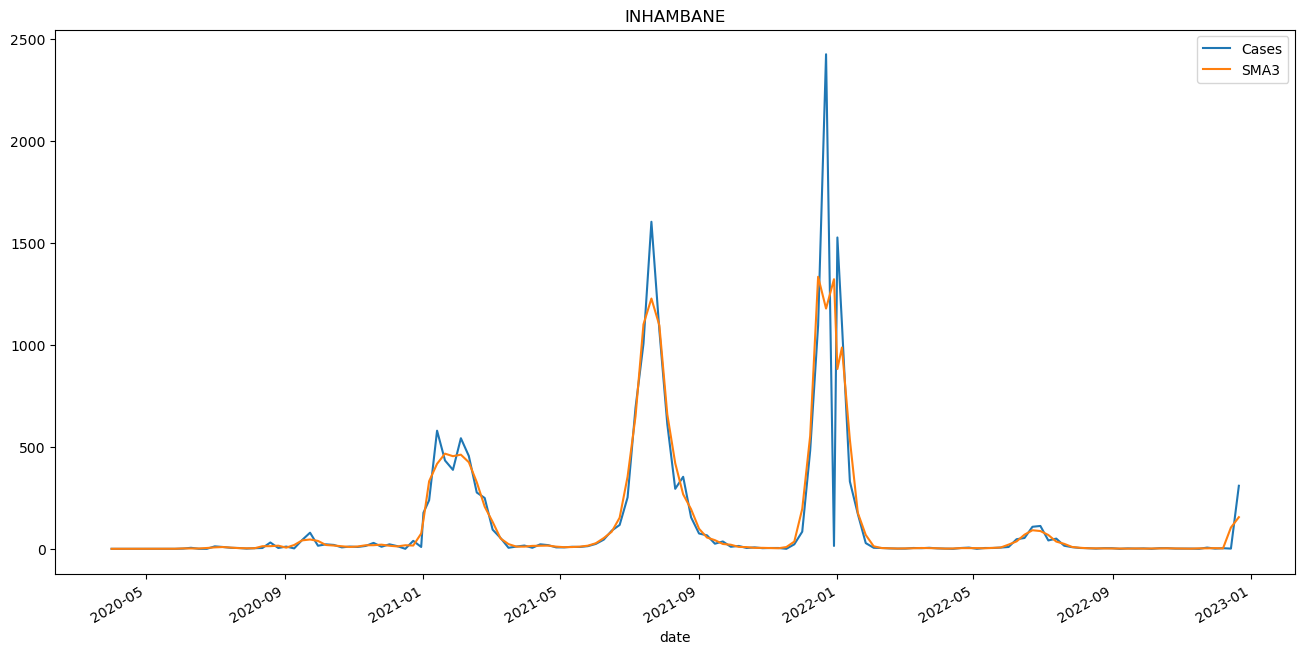

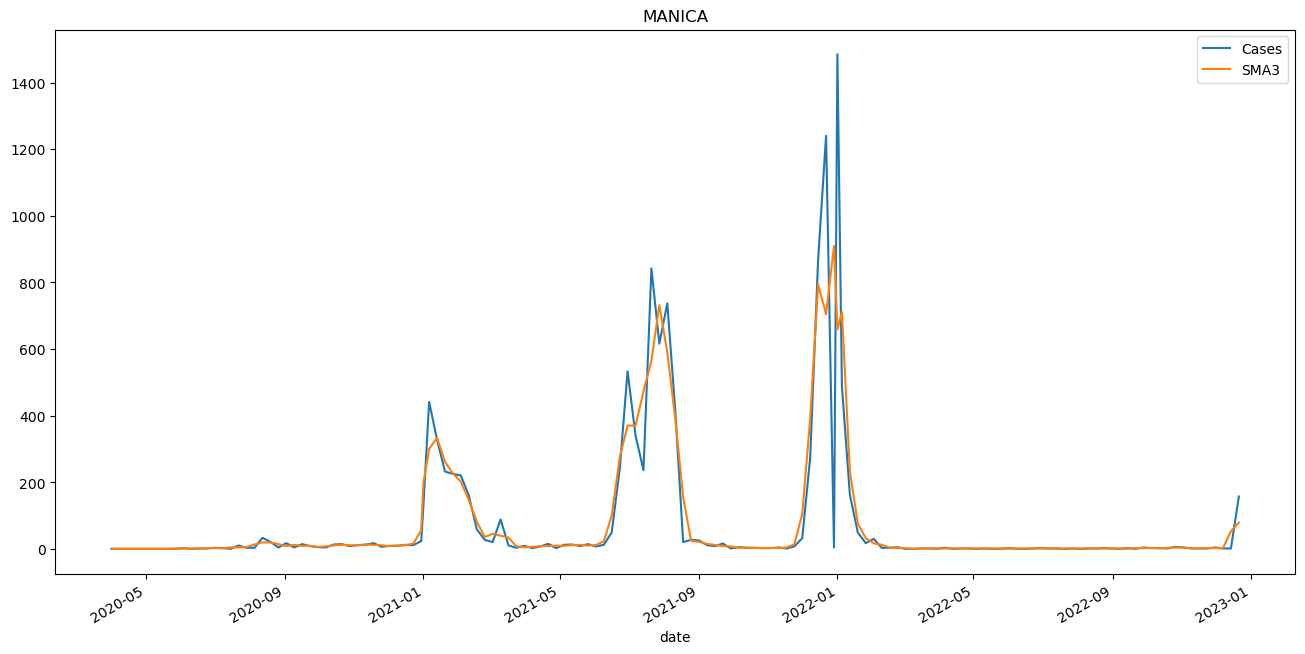

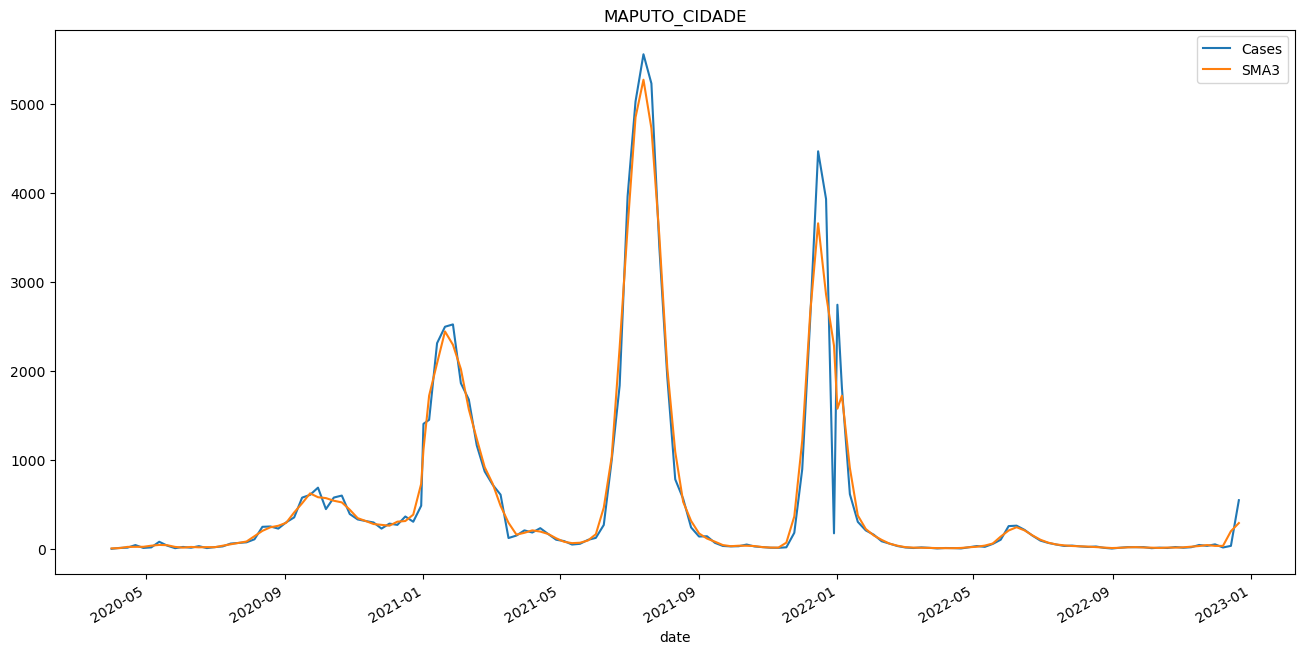

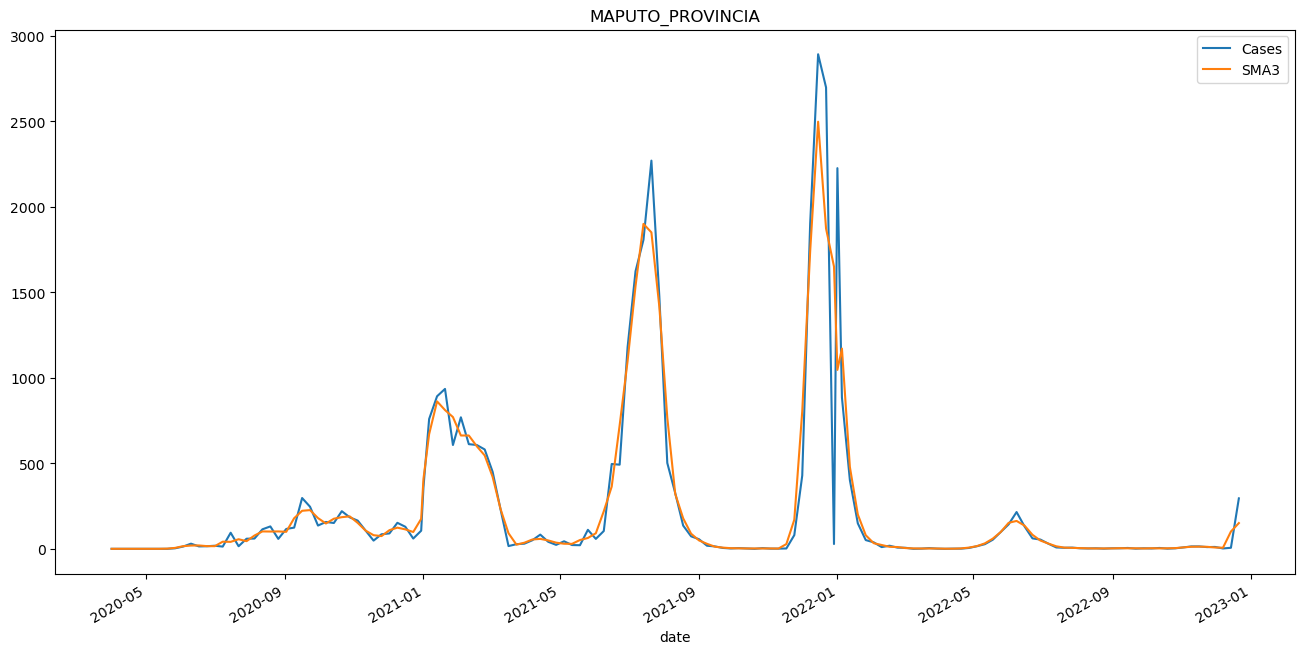

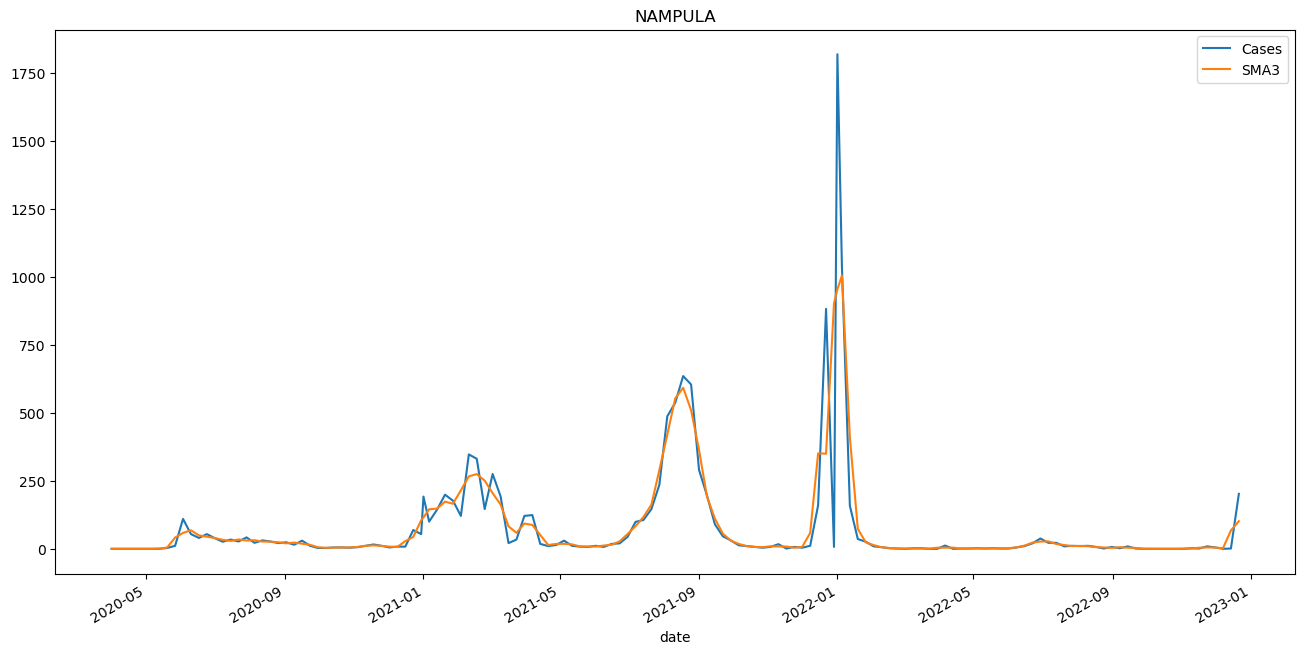

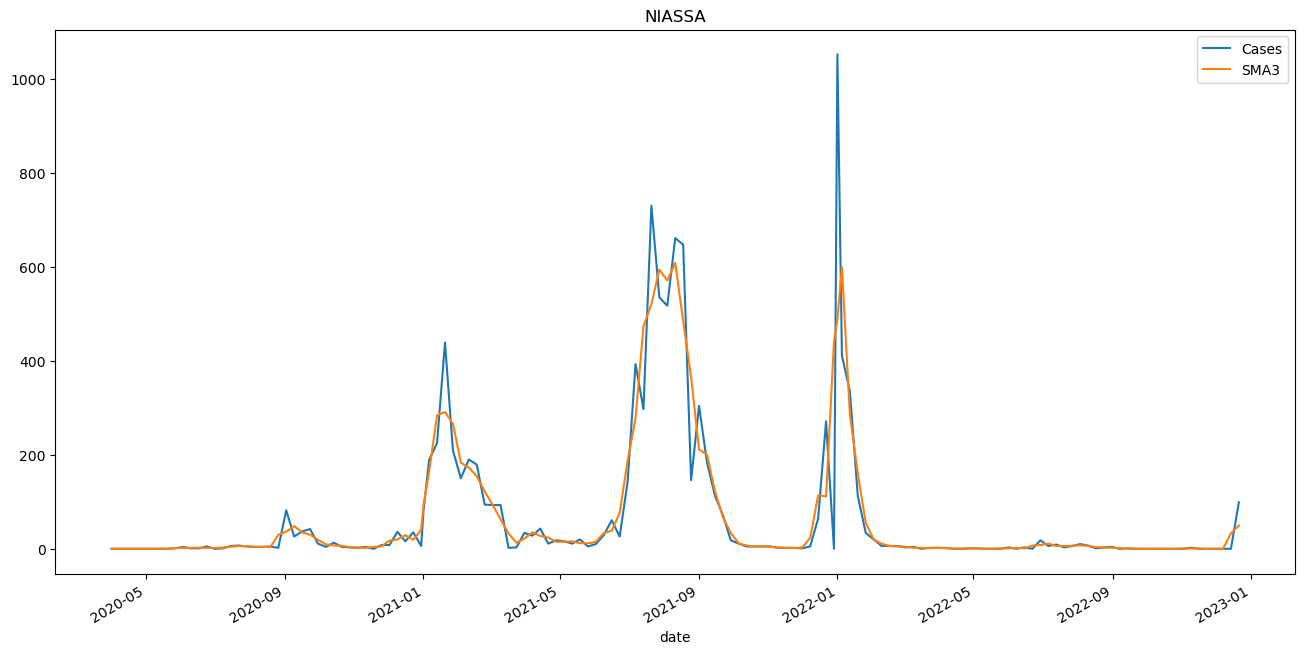

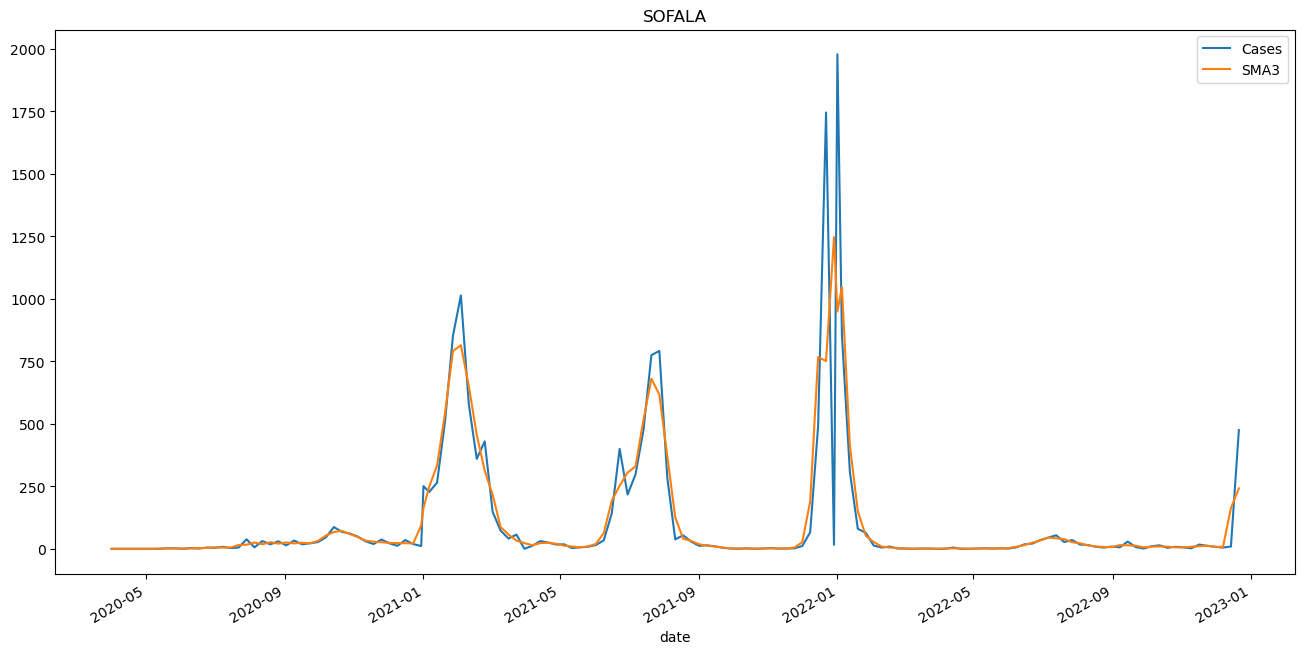

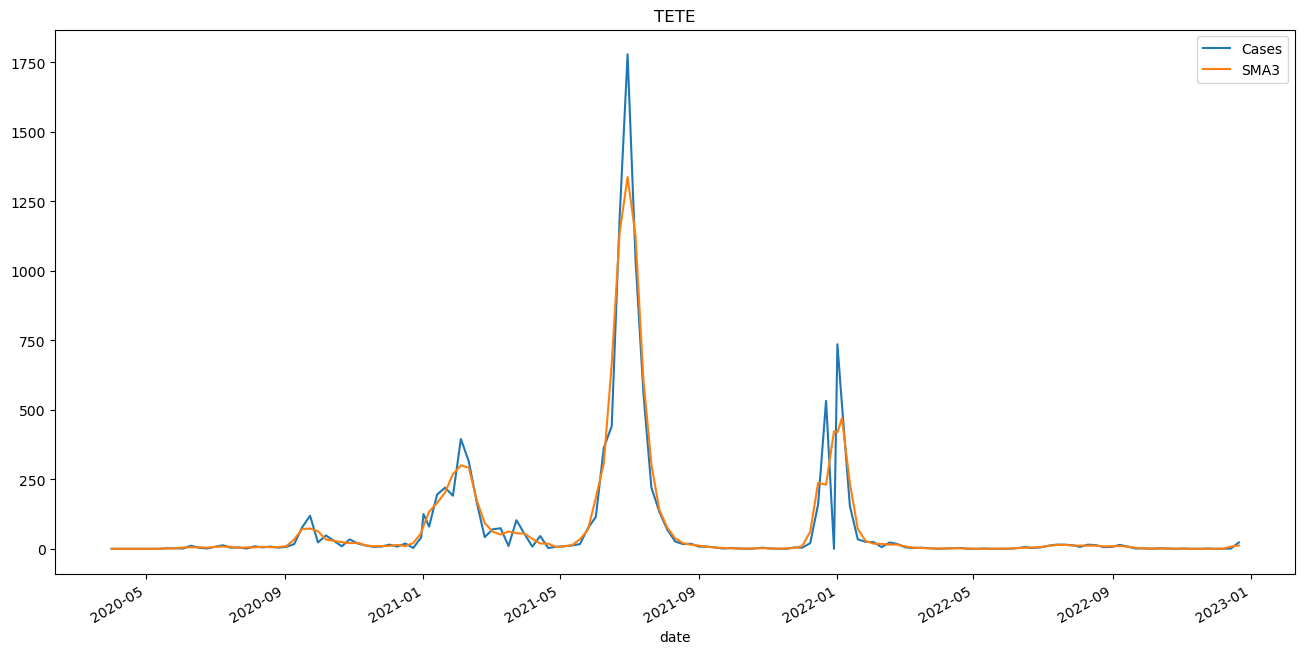

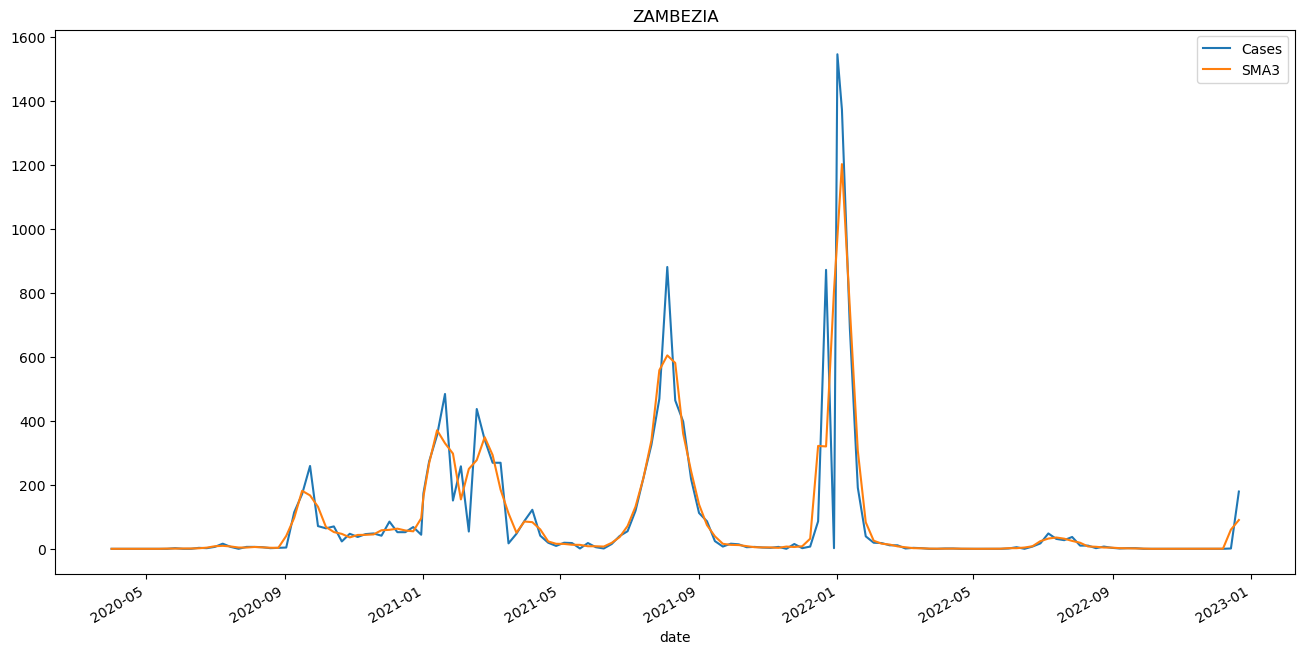

In [23]:
for p in long_province_df.PROVINCE.unique():
    long_province_df.loc[long_province_df['PROVINCE'] == p, ['date','Cases','SMA3']].plot(x="date", figsize=(16, 8),title=p)

# Adaptive Inflation

In [24]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    for _ in range(7):
        dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
        dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered

        # OEV = np.maximum(1., dSI**2 * noise_param)
        # OEV_sample= np.random.normal(0, 1, size=len(dSI))
        # i_noise = dSI + OEV_sample * np.sqrt(OEV)

        # Updates
        x = SIR(
            S = np.clip(x.S - dSI, 0, N),
            I = np.clip(x.I + dSI - dIR, 0, N),
            R = np.clip(x.R + dIR, 0, N),
            i = np.clip(dSI, 0, N)
        )

    return x

def g(x, α):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    # y = np.random.binomial(x.i.astype(int), α)
    return x.i * α

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """

    S0 = np.random.uniform(pop*0.95, pop*0.99, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*t_I)
    return θ0

def eakf(x, y, z, oev, m=300):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,m)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost

In [25]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}



In [26]:
data = long_province_df.loc[long_province_df["PROVINCE"] == "GAZA", "SMA3"]
dates = long_province_df.date.unique()
N = province_df.loc[province_df["PROVINCE"] == "GAZA", "POPULATION"].values[0]
t_I = 4

In [27]:
from tqdm import tqdm

x_list = []
prior_list = []
θ_list = []
lam_list = []

m = 300
α = 1.

for t in range(len(data)):
    if t == 0:
        x = f0(N, m=m)
        θ = θ0(prior, m=m)
    else:
        x = f(t, x, θ, N)  # prediction
        y = g(x, α=α)           # analysis
        z = data.iloc[t]
        
        def _adaptive_inflation(x, y, z, oev, lambar_prior=1.01, siglam2=0.1):
            # step 3b
            sig2p = np.var(y)
            ybarp = np.mean(y)
            D = np.abs(ybarp - z)

            # step 3c
            r = np.cov(x, y)[0,1]  # i
            lam0 = (1. + r*(np.sqrt(lambar_prior) - 1.))**2  # iii
            theta = np.sqrt(lam0 * sig2p + oev)  #iv
            
            
            # v/ Appendix A
            lbar = 1./(np.sqrt(2*np.pi) * theta) * np.exp(-D**2/(2.*theta**2))
            dthetadlam = sig2p * r * (1. - r + r*np.sqrt(lambar_prior))/(2.*theta*np.sqrt(lambar_prior))
            lprime = lbar *(D**2/theta**2 -1.)/theta * dthetadlam
            
            b = lbar/lprime - 2*lambar_prior
            c = lambar_prior**2 - siglam2 - lbar * lambar_prior/lprime
            
            lam1 = np.abs((-b + np.sqrt(b**2 - 4.*c))/2)
            lam2 = np.abs((-b - np.sqrt(b**2 - 4.*c))/2)
            
            # if math.isnan(lam1) or math.isnan(lam2):
            #     import pdb; pdb.set_trace()
            
            if np.abs(lam1 - lambar_prior) < np.abs(lam2 - lambar_prior):
                return lam1
            else:
                return lam2
        
        def _inflate_ensembles(ens, inflation_value, params=False):
            if params:
                _, m = np.asarray(ens).shape
                ens_mean = np.mean(ens, 1, keepdims=True)
                ens_inflated = ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))
            else:
                m = len(ens)
                ens_mean = np.mean(ens)
                ens_inflated = ens_mean * np.ones(m) + inflation_value*(ens - ens_mean*np.ones(m))

            return ens_inflated
        
        
        oev = np.maximum(100, z/1000)
        if t > 50:
            lam = _adaptive_inflation(θ.beta, y, z, oev)
            lam_list.append(lam)
            θ = _inflate_ensembles(θ, inflation_value=1.2, params=True)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
        prior_list.append(x)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, N),
            I = np.clip(x.I, 0, N),
            R = np.clip(x.R, 0, N),
            i = np.clip(x.i, 0, N)
        )
        θ, _ = eakf(θ, y, z, oev=oev, m=m)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)
    
post_i = np.array([x.i for x in x_list])
post_beta = np.array([θ.beta for θ in θ_list])

Text(0.5, 0.98, 'GAZA EAKF full time series adaptive inflation')

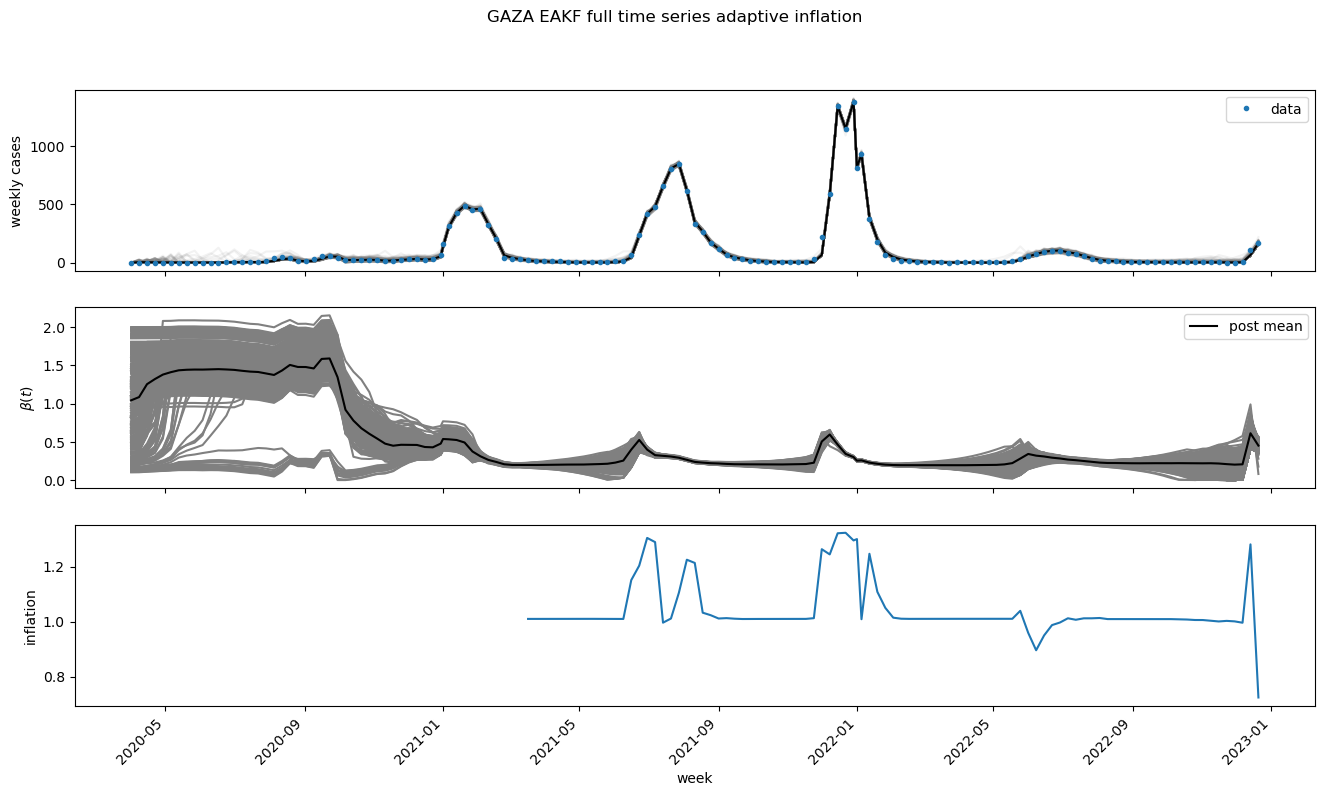

In [28]:
fig, ax = plt.subplots(3, sharex=True, figsize=(16, 8))
ax[0].plot(dates, post_i, color='gray', alpha=0.1)
# ax[0].plot(np.mean([x.i for x in prior_list], axis=1), color='red')
ax[0].plot(dates, np.mean(post_i, axis=1), color='black')
ax[0].plot(dates, data.values, '.', label="data")
ax[0].set_ylabel(r'weekly cases')
ax[0].legend()

ax[1].plot(dates, post_beta, color="gray")
ax[1].plot(dates, np.mean(post_beta, axis=1), color="black", label="post mean")
ax[1].set_ylabel(r'$\beta(t)$')
ax[1].legend()

a = np.empty(51)
a[:] = np.nan
ax[2].plot(dates, np.append(a, lam_list))
ax[2].set_ylabel(r'inflation')
ax[2].set_xlabel('week')


plt.xticks(rotation=45, ha='right')

fig.suptitle('GAZA EAKF full time series adaptive inflation')



In [29]:
lam_list

[1.009618702563273,
 1.0096951872445743,
 1.0098166702513254,
 1.0099153799955047,
 1.0098491915537693,
 1.0098429579655885,
 1.0098643060076142,
 1.009882259936262,
 1.009855015986318,
 1.0097885221621254,
 1.0095047484590935,
 1.0098138704986468,
 1.009492224750673,
 1.1509368349494489,
 1.2034576156016081,
 1.3044230589764194,
 1.289192947450382,
 0.9959476793753947,
 1.011009673407088,
 1.105009241270427,
 1.2250762908233712,
 1.213338977376309,
 1.03227248465055,
 1.023185128377798,
 1.0110904235551175,
 1.0124749902679397,
 1.0104084065568202,
 1.0092519377199949,
 1.0095567314230323,
 1.009473711336355,
 1.0095202495655542,
 1.0096944440832374,
 1.0098205981555566,
 1.0098219187716495,
 1.0097494355590868,
 1.0096963835909207,
 1.01229094313911,
 1.2633677627632167,
 1.2444091945715714,
 1.3213515881261513,
 1.323128368203288,
 1.2952574953335776,
 1.3001171220727352,
 1.0084932162793265,
 1.2466733623484525,
 1.1081915560559565,
 1.049957474302171,
 1.014153997631512,
 1.010319